In [1]:
from lcg_plus.base import State as olga_state
from lcg_plus.plotting import plot_wigner_marginals
from lcg_plus.states.from_sf import prepare_gkp_bosonic
from lcg_plus.fidelity import overlap_log
from thewalrus.symplectic import beam_splitter, squeezing, xxpp_to_xpxp, expand
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
from mrmustard.lab import *
import numpy as np
from time import time

## Comparing performance of a fixed circuit between MrMustard and lcg_plus

In [3]:
def mrmustard_circuit(nmodes, r, eta, n):

    state = Vacuum(nmodes)
    for i in range(nmodes):
        state = state >> Sgate(r, i%2*np.pi)[i]
        
    for i in range(nmodes):
        if i < nmodes -1:
            BS = BSgate(modes=[i,i+1],theta = np.pi/4)
            state = state >> BS
    if eta != 1:
        
        state = state >> Attenuator(eta, modes = range(nmodes))
        
    
    state_post = state << Fock([n]*(nmodes-1), range(nmodes-1))

    return state_post
           

In [4]:
def bosonicplus_circuit(nmodes, r, eta, n, inf = 1e-4):
    state = olga_state(nmodes)
    bs = xxpp_to_xpxp(beam_splitter(np.pi/4,0))

    for i in range(nmodes):
        
        state.apply_symplectic_fast(xxpp_to_xpxp(squeezing(r, i%2*np.pi)),[i])
    for i in range(nmodes):
        if i < nmodes-1:
            state.apply_symplectic_fast(bs, [i,i+1])
    if eta != 1:
        state.apply_loss(np.repeat(eta,nmodes),np.zeros(nmodes))
    
    
    for i in range(nmodes-1):
        state.post_select_fock_coherent(0,n,inf=inf,red_gauss =True)

    if eta == 1:
        state.reduce_pure(n*(nmodes-1))
    else:
        state.reduce_mixed()
    prob = state.norm
    return state, prob
    

6.945217371061863e-05
12.14485216140747


#### State

| Purity | Probability | Num modes | Bosonic size | Gaussian | Fock |
| :----: | :----: | :----: | :----: | :----: | :----: |
| 1.63e-01 | 6.945e-03 % | 1 | N/A | ❌ | ✅ |

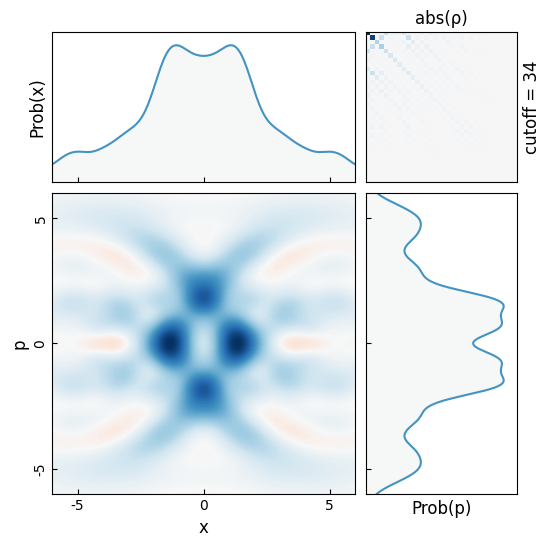

In [5]:
t0 = time()
state = mrmustard_circuit(4,1.5,0.9,7)
print(state.probability)
t1 = time()
print(t1-t0)
state


0.9999999999999993
171


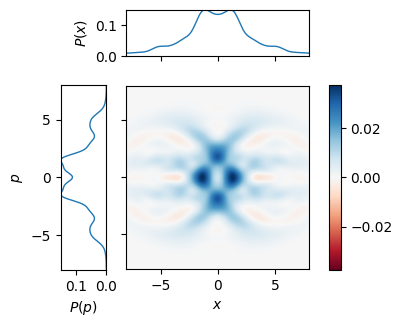

4.754245042800903


In [6]:
t0 = time()
state, prob = bosonicplus_circuit(4,1.5,0.9,7, inf = 1e-6)
print(prob)
t1 = time()

x = np.linspace(-8,8,200)
print(state.num_weights)

W = state.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()

print(t1-t0)

## First, do the lossless comparison

In [7]:
modes = np.array([3,4])
photons = np.array([1,2,5,7])

times_mm = np.zeros((len(modes),len(photons), 2))
times_bp = np.zeros((len(modes),len(photons), 2))

r = 1.5
eta = 1


for i, m in enumerate(modes):
    for j, n in enumerate(photons):
        print(f'modes {m}, detecting {n} photons')
        
        t1 = %timeit -o mrmustard_circuit(m,r,eta,n)
        
        times_mm[i,j,0] = t1.average

        t2 = %timeit -o bosonicplus_circuit(m,r,eta,n)
               
        times_bp[i,j,0] = t2.average
        

modes 3, detecting 1 photons
2.4 ms ± 177 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 38.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 2 photons
2.3 ms ± 35.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 9.14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 5 photons
2.32 ms ± 26 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.18 ms ± 20.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 3, detecting 7 photons
2.36 ms ± 34.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.38 ms ± 269 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 4, detecting 1 photons
3.05 ms ± 39.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.68 ms ± 14.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 4, detecting 2 photons
3.12 ms ± 118 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.05 ms ± 82.1 μs per loop (mean ± 

## Now, with loss

In [8]:
eta = 0.9

for i, m in enumerate(modes):
    for j, n in enumerate(photons):
        print(f'modes {m}, detecting {n} photons')
        t1 = %timeit -o mrmustard_circuit(m,r,eta,n)
        
        times_mm[i,j,1] = t1.average

        t2 = %timeit -o bosonicplus_circuit(m,r,eta,n)
               
        times_bp[i,j,1] = t2.average

modes 3, detecting 1 photons
3.36 ms ± 80.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.73 ms ± 110 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 2 photons
5.38 ms ± 238 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.76 ms ± 375 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 3, detecting 5 photons
44.2 ms ± 486 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.7 ms ± 693 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 3, detecting 7 photons
135 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
57.1 ms ± 775 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
modes 4, detecting 1 photons
5.46 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.62 ms ± 198 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 4, detecting 2 photons
26 ms ± 105 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.18 ms ± 99 μs per loop (mean ± std. dev. of 7 

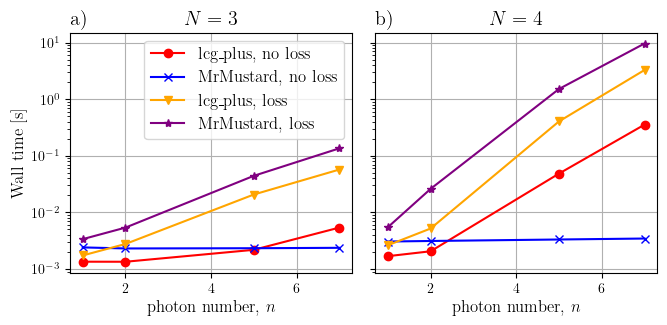

In [9]:
colwidth = 3.41667
fs = 12
mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 10, 
                     'ytick.labelsize':10 })

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}


fig, axes = plt.subplots(1,2,figsize =(2*colwidth, colwidth),sharey=True,sharex=True)


for i, m in enumerate(modes):
    axes[i].plot(photons,times_bp[i,:,0], marker='o',markersize = 6, color = 'red', label = 'lcg_plus, no loss')
    axes[i].plot(photons,times_mm[i,:,0], marker = 'x', markersize=6, color ='blue', label = 'MrMustard, no loss')    
    axes[i].plot(photons,times_bp[i,:,1], marker = 'v', markersize =6, color = 'orange',label='lcg_plus, loss')
    axes[i].plot(photons,times_mm[i,:,1], marker = '*', markersize=6, color ='purple', label = 'MrMustard, loss')
    axes[i].set_yscale('log')

#fig.suptitle('Time of calculating an output state')
axes[0].set_title(r'$N=3$')
axes[0].set_title('a)', loc ='left')
axes[1].set_title(r'$N=4$')
axes[1].set_title('b)', loc ='left')
axes[0].set_xlabel('photon number, $n$')
axes[1].set_xlabel('photon number, $n$')
axes[0].set_ylabel('Wall time [s]')
axes[0].legend()
axes[0].grid('on')
axes[1].grid('on')
fig.set_tight_layout('tight')
fig.savefig('thesis_figures/mrmustard_comparison.pdf',**fig_kwargs)
plt.show()